# Data Exploration

In [ ]:
!conda install dask distributed --yes

In [1]:
!pip install 'bokeh==0.13.0'
# restart the notebook for the packages to be updated 

In [2]:
import os

# Dataframes
import v3io_frames as v3f
import dask.dataframe as dd
from dask.distributed import Client, progress
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt; plt.rcdefaults()
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column, row, gridplot
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral11
import seaborn as sns; sns.set()


output_notebook()
%matplotlib inline

Loading BokehJS ...

## Explore data
Access the time-series and run a queries to learn about the data

In [3]:
client = v3f.Client('framesd:8081')
client.read(backend='tsdb', query='select sum(throughput) from netops_metrics_jupyter',
            start="now-2d", end='now+1d', multi_index=True)

sum(throughput)
time                company                   data_center      device                        
2019-03-03 14:49:49 Boyd-Faulkner             Nancy_Mall       3916108545629        227774.25
                                              Barrett_Crossing 5728297877286        229665.63
                    Wheeler__Shelton_and_Hill Dean_Park        2368397418989        230474.78
                    Boyd-Faulkner             Nancy_Mall       7542919702594        237805.21
                    Wheeler__Shelton_and_Hill Cindy_Rapids     0847959813128        225244.33
                                              Dean_Park        1184469177528        222587.38
                    Boyd-Faulkner             Barrett_Crossing 8566530842848        232060.10
                    Wheeler__Shelton_and_Hill Cindy_Rapids     4963294562966        226319.31

In [4]:
# read the devices table 
devicedf = client.read(backend='kv', table='netops_devices')
devicedf.head()

,company,data_center
__name,,
5728297877286,Boyd-Faulkner,Barrett_Crossing
8566530842848,Boyd-Faulkner,Barrett_Crossing
7542919702594,Boyd-Faulkner,Nancy_Mall
1184469177528,Wheeler__Shelton_and_Hill,Dean_Park
3916108545629,Boyd-Faulkner,Nancy_Mall


## Sample device
Select a single device and explore its parameters

In [5]:
# use the first device ID for exploration
first_device = devicedf.index.values[0]
query = "select * from netops_metrics_jupyter where device='{}'".format(first_device)
sample_device = client.read(backend='tsdb', query=query, start="now-2d", end='now+1d', multi_index=True)
sample_device.head()

,,,,packet_loss,cpu_utilization_is_error,packet_loss_is_error,throughput_is_error,latency_is_error,cpu_utilization,latency,is_error,throughput
time,company,data_center,device,,,,,,,,,
2019-03-05 14:38:47.338,Boyd-Faulkner,Barrett_Crossing,5728297877286,0.0,0.0,0.0,0.0,0.0,85.61,0.00,0.0,258.25
2019-03-05 14:38:53.338,Boyd-Faulkner,Barrett_Crossing,5728297877286,0.0,0.0,0.0,0.0,0.0,66.44,2.73,0.0,246.00
2019-03-05 14:38:59.338,Boyd-Faulkner,Barrett_Crossing,5728297877286,1.0,0.0,0.0,0.0,0.0,51.59,6.22,0.0,241.59
2019-03-05 14:39:05.338,Boyd-Faulkner,Barrett_Crossing,5728297877286,1.0,0.0,0.0,0.0,0.0,76.13,0.00,0.0,205.02
2019-03-05 14:39:11.338,Boyd-Faulkner,Barrett_Crossing,5728297877286,0.0,0.0,0.0,0.0,0.0,79.37,0.00,0.0,258.27


Reading as CSV file and processing in parallel with Dask

### Examine Metrics

In [6]:
sample_component_performance = sample_device['cpu_utilization'] 
p = figure(title="Sample Performance Generation [ CPU Utilization ]",
            x_axis_label="ticks",
            y_axis_label="CPU Utilization (%)",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance, 
    legend="Utilization (%)")
show(p)
print(sample_component_performance.describe())

count    1000.000000
mean       73.700020
std        12.923543
min        43.300000
25%        64.447500
50%        71.725000
75%        79.980000
max       100.000000
Name: cpu_utilization, dtype: float64


In [7]:
sample_component_performance = sample_device['latency']
p = figure(title="Sample Performance Generation [ Latency ]",
            x_axis_label="ticks",
            y_axis_label="Latency (ms)",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance, 
    legend="Latency (ms)")
show(p)
print(sample_component_performance.describe())

count    1000.00000
mean       11.74410
std        29.40257
min         0.00000
25%         0.00000
50%         0.63500
75%         5.12750
max       100.00000
Name: latency, dtype: float64


In [8]:
sample_component_performance = sample_device['packet_loss']
p = figure(title="Sample Performance Generation [ Packet loss ]",
            x_axis_label="ticks",
            y_axis_label="Packet loss",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance, 
    legend="Packet loss")
show(p)
print(sample_component_performance.describe())

count    1000.00000
mean        5.20100
std        14.13798
min         0.00000
25%         0.00000
50%         0.00000
75%         2.00000
max        50.00000
Name: packet_loss, dtype: float64


In [9]:
sample_component_performance = sample_device['throughput']
p = figure(title="Sample Performance Generation [ Throughput ]",
            x_axis_label="ticks",
            y_axis_label="Throughput",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance, 
    legend="Throughput")
show(p)
print(sample_component_performance.describe())

count    1000.000000
mean      229.665630
std        71.218357
min         0.000000
25%       232.895000
50%       247.685000
75%       263.042500
max       300.000000
Name: throughput, dtype: float64


In [10]:
sample_component_performance = sample_device['is_error']
p = figure(title="Sample Performance Generation [ All + Error ]",
            x_axis_label="ticks",
            y_axis_label="Metrics",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance-5, 
    legend="Error",
    color='red')
p.line(x=range(len(sample_component_performance)), 
    y=sample_device['cpu_utilization'], 
    legend="cpu_utilization",
    color='blue')
p.line(x=range(len(sample_component_performance)), 
    y=sample_device['latency'], 
    legend="latency",
    color='green')
p.line(x=range(len(sample_component_performance)), 
    y=sample_device['throughput'], 
    legend="throughput",
    color='black')
p.line(x=range(len(sample_component_performance)), 
    y=sample_device['packet_loss'], 
    legend="packet_loss",
    color='orange')
show(p)

## Find Correlations Using Parallel Processing
in order to find correlation we will use Dask, a parallel python computation framework <br>
Dask can run in the same container or on a multi-node cluster, we demonstrate a local environment<br>
for a distributed cluster configuration make sure the dask service is deployed on your Kubernetes<br>
use `Client('dask-scheduler:8786')` for a cluster or `Client()` for Dask local

In [11]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:42591 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 65.84 GB


In [12]:
df = dd.from_pandas(client.read(backend='tsdb', query='select * from netops_metrics_jupyter',
            start="now-2d", end='now+1d', multi_index=True).reset_index(), npartitions=4)
df.head()

,time,device,company,data_center,cpu_utilization_is_error,packet_loss_is_error,cpu_utilization,throughput_is_error,latency,is_error,throughput,latency_is_error,packet_loss
0,2019-03-05 14:38:47.338,5728297877286,Boyd-Faulkner,Barrett_Crossing,0.0,0.0,85.61,0.0,0.00,0.0,258.25,0.0,0.0
1,2019-03-05 14:38:53.338,5728297877286,Boyd-Faulkner,Barrett_Crossing,0.0,0.0,66.44,0.0,2.73,0.0,246.00,0.0,0.0
2,2019-03-05 14:38:59.338,5728297877286,Boyd-Faulkner,Barrett_Crossing,0.0,0.0,51.59,0.0,6.22,0.0,241.59,0.0,1.0
3,2019-03-05 14:39:05.338,5728297877286,Boyd-Faulkner,Barrett_Crossing,0.0,0.0,76.13,0.0,0.00,0.0,205.02,0.0,1.0
4,2019-03-05 14:39:11.338,5728297877286,Boyd-Faulkner,Barrett_Crossing,0.0,0.0,79.37,0.0,0.00,0.0,258.27,0.0,0.0


In [13]:
X = df.compute()
correlations = X[['cpu_utilization', 'latency', 'throughput', 'packet_loss', 'is_error']].corr()
correlations

,cpu_utilization,latency,throughput,packet_loss,is_error
cpu_utilization,1.000000,0.606347,-0.513919,0.554977,0.544101
latency,0.606347,1.000000,-0.757744,0.829942,0.805780
throughput,-0.513919,-0.757744,1.000000,-0.793225,-0.884912
packet_loss,0.554977,0.829942,-0.793225,1.000000,0.854695
is_error,0.544101,0.805780,-0.884912,0.854695,1.000000


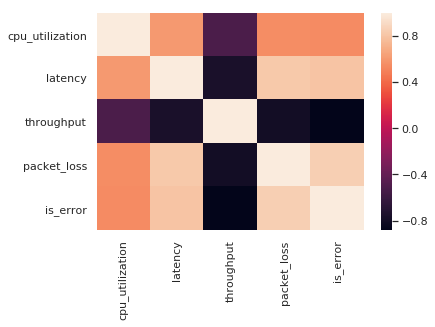

In [14]:
sns.heatmap(correlations)